# Recurrent Neural Networks

In [66]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import TensorBoard

## Time series forecasting

In [2]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [3]:
from pandas.tseries.offsets import MonthEnd

In [4]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


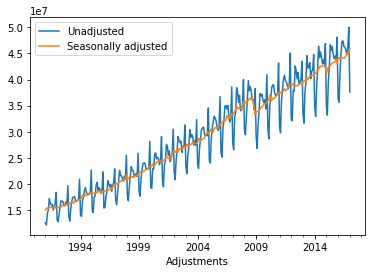

In [5]:
df.plot()

In [6]:
split_date = pd.Timestamp('01-01-2011')

In [7]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

In [8]:
print (train.head())
print (test.head())

             Unadjusted
Adjustments            
1991-01-31     12588862
1991-02-28     12154321
1991-03-31     14337072
1991-04-30     15108570
1991-05-31     17225734
             Unadjusted
Adjustments            
2011-01-31     31191594
2011-02-28     29797949
2011-03-31     36099866
2011-04-30     38035760
2011-05-31     40046516


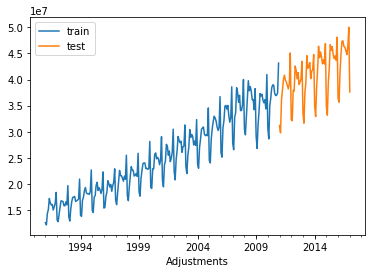

In [9]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [10]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

/home/ankdesh/virtualenvs/kaggle-google-doodle/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
train_sc[:4]

array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795]])

In [12]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [13]:
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(239, 1) (239, 1) (72, 1) (72, 1)


In [14]:
print (np.hstack((X_train[:5], y_train[:5])))

[[0.01402033 0.        ]
 [0.         0.0704258 ]
 [0.0704258  0.09531795]
 [0.09531795 0.16362761]
 [0.16362761 0.13514108]]


### Fully connected predictor

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [17]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=0)

In [18]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=0,
          callbacks=[early_stop])

In [19]:
y_pred = model.predict(X_test)

In [20]:
print (np.hstack((y_test[:5], y_pred[:5])))

[[0.56926634 0.60516173]
 [0.77259579 0.56453431]
 [0.83505683 0.74319726]
 [0.89993326 0.78982466]
 [0.92552046 0.83825505]]


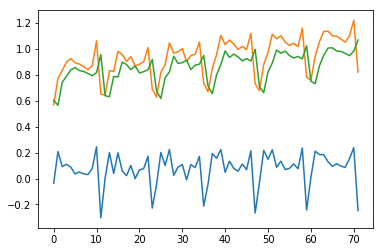

In [21]:
plot = plt.plot()
plt.plot(y_test[:] - y_pred[:])
plt.plot(y_test)
plt.plot(y_pred)
plt.show()

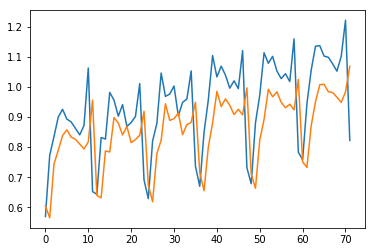

In [22]:
plt.plot(y_test)
plt.plot(y_pred)

In [23]:
print (mse(y_pred,y_test))

0.021061096295750734


### Recurrent predictor

In [24]:
from tensorflow.keras.layers import LSTM

In [25]:
X_train.shape

(239, 1)

In [26]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train[:, None].shape

(239, 1, 1)

In [27]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [28]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 192       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=0,
          callbacks=[early_stop])

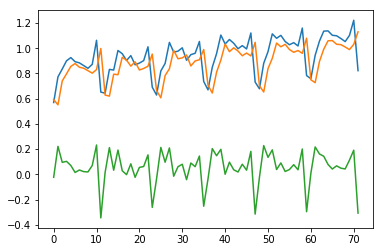

In [31]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)
plt.plot(y_test - y_pred)

In [32]:
print (mse(y_pred,y_test))

0.0196947390630087


## Windows

In [33]:
train_sc.shape

(240, 1)

In [34]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [35]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [36]:
train_sc_df.head(15)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [37]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [38]:
X_train.head(13)

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628
1992-06-30,0.149130,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141
1992-07-31,0.147189,0.149130,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958
1992-08-31,0.144648,0.147189,0.149130,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174
1992-09-30,0.118984,0.144648,0.147189,0.149130,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309


In [39]:
X_train.shape

(228, 12)

In [40]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

### Fully Connected on Windows

In [41]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=0, callbacks=[early_stop])

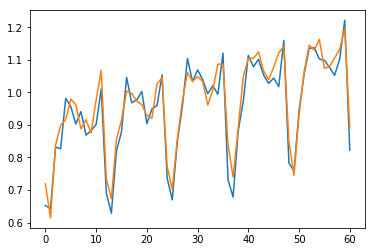

In [43]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

In [44]:
print (mse(y_pred,y_test))

0.001944050203450335


### LSTM on Windows

In [45]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [46]:
X_train_t.shape

(228, 1, 12)

In [47]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 456       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=0, callbacks=[early_stop])

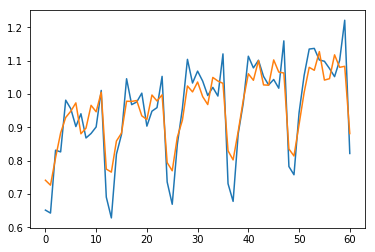

In [50]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

In [51]:
print (mse(y_pred,y_test))

0.0035213515332676248


## Exercise 1

In the model above we reshaped the input shape to: `(num_samples, 1, 12)`, i.e. we treated a window of 12 months as a vector of 12 coordinates that we simultaneously passed to all the LSTM nodes. An alternative way to look at the problem is to reshape the input to `(num_samples, 12, 1)`. This means we consider each input window as a sequence of 12 values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions? Let's check it.

- Reshape `X_train` and `X_test` so that they represent a set of univariate sequences
- retrain the same LSTM(6) model, you'll have to adapt the `input_shape`
- check the performance of this new model, is it better at predicting the test data?

In [52]:
print (X_train.shape,X_test.shape)

(228, 12) (61, 12)


In [55]:
X_train = X_train.reshape(-1, 12, 1)
X_test = X_test.reshape(-1, 12, 1)

In [56]:
print (X_train.shape,X_test.shape)

(228, 12, 1) (61, 12, 1)


In [57]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(12, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 192       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.fit(X_train, y_train, epochs=100,
          batch_size=1, verbose=0, callbacks=[early_stop,TensorBoard()])

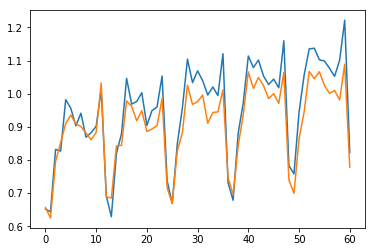

In [70]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

In [71]:
print (mse(y_pred,y_test))

0.003394159404671076


## Exercise 2

RNN models can be applied to images too. In general we can apply them to any data where there's a connnection between nearby units. Let's see how we can easily build a model that works with images.

- Load the MNIST data, by now you should be able to do it blindfolded :)
- reshape it so that an image looks like a long sequence of pixels
- create a recurrent model and train it on the training data
- how does it perform compared to a fully connected? How does it compare to Convolutional Neural Networks?

(feel free to run this exercise on a cloud GPU if it's too slow on your laptop)

In [112]:
import tensorflow.keras.datasets.mnist as mnist
from tensorflow.keras.utils import to_categorical 
from sklearn.metrics import accuracy_score

In [81]:
(X_train, y_train), (X_test, y_test) = mnist.load_data('/tmp/mnist.npz')

11493376/11490434 [==============================] - 3s 0us/step


In [83]:
print (X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [86]:
X_train_t = X_train.reshape(-1, 784, 1)
X_test_t = X_test.reshape(-1, 784, 1)

In [87]:
print (X_train_t.shape)

(60000, 784, 1)


In [99]:
y_train = to_categorical(y_train,num_classes=10)

In [100]:
y_test = to_categorical(y_test,num_classes=10)

In [108]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(784, 1)))

model.add(Dense(10,activation='softmax'))

model.compile(loss='mean_squared_error', optimizer='adam')

In [109]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 192       
_________________________________________________________________
dense (Dense)                (None, 10)                70        
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________


In [110]:
model.fit(X_train_t, y_train, epochs=10,
          batch_size=1024, verbose=1, callbacks=[early_stop,TensorBoard()])

Epoch 1/10
60000/60000 [==============================] - 49s 824us/step - loss: 0.0900
Epoch 2/10
60000/60000 [==============================] - 48s 795us/step - loss: 0.0900
Epoch 3/10
60000/60000 [==============================] - 47s 775us/step - loss: 0.0900
Epoch 4/10
60000/60000 [==============================] - 47s 788us/step - loss: 0.0897
Epoch 5/10
60000/60000 [==============================] - 46s 775us/step - loss: 0.0857
Epoch 6/10
60000/60000 [==============================] - 46s 770us/step - loss: 0.0837
Epoch 7/10
60000/60000 [==============================] - 46s 771us/step - loss: 0.0830
Epoch 8/10
60000/60000 [==============================] - 46s 768us/step - loss: 0.0823
Epoch 9/10
60000/60000 [==============================] - 46s 770us/step - loss: 0.0813
Epoch 10/10
60000/60000 [==============================] - 46s 769us/step - loss: 0.0804


In [111]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1024, verbose=1, callbacks=[early_stop,TensorBoard()])

Epoch 1/100
60000/60000 [==============================] - 46s 773us/step - loss: 0.0797
Epoch 2/100
60000/60000 [==============================] - 46s 769us/step - loss: 0.0792
Epoch 3/100
60000/60000 [==============================] - 46s 770us/step - loss: 0.0789
Epoch 4/100
60000/60000 [==============================] - 46s 771us/step - loss: 0.0788
Epoch 5/100
60000/60000 [==============================] - 46s 773us/step - loss: 0.0784
Epoch 6/100
60000/60000 [==============================] - 46s 770us/step - loss: 0.0781
Epoch 7/100
60000/60000 [==============================] - 46s 774us/step - loss: 0.0779
Epoch 8/100
60000/60000 [==============================] - 46s 769us/step - loss: 0.0777
Epoch 9/100
60000/60000 [==============================] - 46s 771us/step - loss: 0.0775
Epoch 10/100
60000/60000 [==============================] - 46s 771us/step - loss: 0.0773
Epoch 11/100
60000/60000 [==============================] - 46s 770us/step - loss: 0.0772
Epoch 12/100
60000/

In [115]:
y_pred = model.predict(X_test_t)

In [120]:
print (y_pred.shape, y_test.shape)

(10000, 10) (10000, 10)


In [124]:
y_pred_argmax = np.argmax(y_pred,axis=1)

In [126]:
y_test_argmax = np.argmax(y_test,axis=1)

In [127]:
accuracy_score(y_test_argmax,y_pred_argmax)

0.363